# LSTM(Long Short-Term Memory) 구조 

<img src = './image/rnn_lstm.jpg'>

- 단기 기억을 오래 기억하기 위해 고안되었음 

<img src = './image/lstm.png'>

- 은닉 상태를 만드는 방법
    - output gate layer(출력 게이트)
        1. 입력과 이전 타임스텝의 은닉 상태를 가중치에 곱한 후 활성화 함수를 통과시켜 다음 은닉상태를 만듦
            - 이 때 기본 순환층과는 달리 시그모이드 활성화 함수를 사용 
        2. tanh 활성화 함수를 통과한 값과 곱해져서 은닉 상태를 만듦 
        
- LSTM 은 순환 되는 상태가 2개
    - 은닉 상태
    - 셀 상태(cell state)
        - cell state은 다음 층으로 전달되지 않고 LSTM 셀에서 순환만 되는 값 
        
- 셀 상태를 계산하는 과정
    - forget gate layer(삭제 게이트)
        - 정보를 제거하는 역할
        1. 입력과 은닉 상태를 또 다른 가중치에 곱한 다음 시그모이드 함수를 통과 
        2. 이전 타임스텝의 셀 상태와 곱하여 새로운 셀 상태를 만듦 
            - 이 셀 상태가 오른쪽에서 tanh 함수를 통과하여 새로운 은닉 상태(hidden state)을 만드는 데 기여 
    
    - input gate layer(입력 게이트)
        - 새로운 정보를 셀 상태에 추가 
        1. 입력과 은닉 상태를 각기 다른 가중치에 곱함
        2. 하나는 시그모이드 함수, 하나는 tanh 함수를 통과
        3. 두 결과를 곱함
        4. 그 결과를 이전 셀 상태와 더함 

## 데이터 준비

In [25]:
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow import keras
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [26]:
# 데이터 로드
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words = 500)

- num_words : 원래는 분석을 통해서 몇개 쓸지 정하는 것임

In [28]:
# 훈련 세트와 검증 세트로 나누기
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.2,
                                                  random_state = 12)

In [30]:
# 패딩
train_seq = pad_sequences(x_train, maxlen= 100)
val_seq = pad_sequences(x_val, maxlen = 100)

In [8]:
train_seq.shape

(20000, 100)

In [9]:
val_seq.shape

(5000, 100)

In [7]:
# LSTM 모델 생성
model = keras.Sequential()
model.add(keras.layers.Embedding(500, 32, input_shape = (100, ))) # 100 개의 단어를 쓸것임
model.add(keras.layers.LSTM(8)) # 유닛 8 개를 쓺 
model.add(keras.layers.Dense(1, activation = 'sigmoid'))

In [10]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ (None, 100, 32)             │          16,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 8)                   │           1,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │               9 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 17,321 (67.66 KB)

 Trainable params: 17,321 (67.66 KB)

 Non-trainable params: 0 (0.00 B)

- LSTM 셀 파라미터 개수
    - ((8 유닛 수 * 8유닛 수) + (32입력값의 수 * 8유닛 수) + 8유닛 수) * 4 = 1312 

In [11]:
rmsprop = keras.optimizers.RMSprop(learning_rate= 1e-4)
model.compile(optimizer= rmsprop, loss= 'binary_crossentropy', metrics = ['accuracy'])
checkpoint_cb = keras.callbacks.ModelCheckpoint('./model/best-lstm-model.keras',
                                                save_best_only= True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience = 4, restore_best_weights= True)

In [12]:
history= model.fit(train_seq, y_train, epochs= 100, batch_size = 64,
                   validation_data= (val_seq, y_val),
                   callbacks= [checkpoint_cb, early_stopping_cb])

Epoch 1/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - accuracy: 0.5255 - loss: 0.6922 - val_accuracy: 0.5840 - val_loss: 0.6885
Epoch 2/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - accuracy: 0.6157 - loss: 0.6846 - val_accuracy: 0.6486 - val_loss: 0.6638
Epoch 3/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - accuracy: 0.6994 - loss: 0.6429 - val_accuracy: 0.7154 - val_loss: 0.6050
Epoch 4/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - accuracy: 0.7288 - loss: 0.5923 - val_accuracy: 0.7316 - val_loss: 0.5756
Epoch 5/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - accuracy: 0.7475 - loss: 0.5641 - val_accuracy: 0.7430 - val_loss: 0.5511
Epoch 6/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - accuracy: 0.7681 - loss: 0.5331 - val_accuracy: 0.7592 - val_loss: 0.5340
Epoch 7/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - accuracy: 0.7812 - loss: 0.5095 - val_accuracy: 0.7542 - val_loss: 0.5206
Epoch 8/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - accuracy: 0.7832 - loss: 0.4969 - 

- simpleRNN 보다는 성능이 좋아질 확률이 높음 
- 어떤 원리로 이런 값이 나오는지 설명 잘하기 

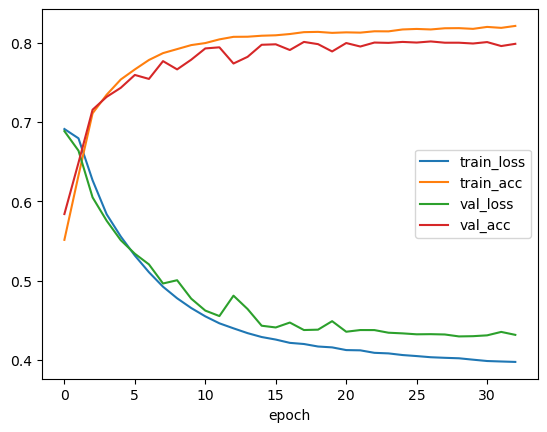

In [13]:
plt.figure()

plt.plot(history.history['loss'], label = 'train_loss')
plt.plot(history.history['accuracy'], label = 'train_acc')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.plot(history.history['val_accuracy'], label = 'val_acc')

plt.legend()
plt.xlabel('epoch')
plt.show()

# 순환층에 드롭아웃 적용 

- 순환층은 자체적으로 드롭아웃 기능을 제공 
    - Simple과 LSTM 클래스 모두 dropout 매개변수와 recurrent_dropout 매개변수를 가지고 있음 
        - dropout : 셀의 입력에 드롭아웃을 적용
        - recurrent_dropout : 순환되는 은닉 상태에 드롭아웃을 적용 
            - 버전에 따라 recurrent_dropout 이 GPU를 사용하지 못하는 경우가 있음 (우리는 GPU가 지금 없지만, 딥러닝 난수제거를 하지 않는 이유와 같음) 

In [14]:
model2 = keras.Sequential()
model2.add(keras.layers.Embedding(500, 32, input_shape = (100,)))
model2.add(keras.layers.LSTM(8, dropout = 0.3)) # 드롭아웃
model2.add(keras.layers.Dense(1, activation = 'sigmoid'))

In [15]:
rmsprop = keras.optimizers.RMSprop(learning_rate= 1e-4)
model2.compile(optimizer= rmsprop, loss= 'binary_crossentropy', metrics = ['accuracy'])
checkpoint_cb = keras.callbacks.ModelCheckpoint('./model/best-dropout-model.keras',
                                                save_best_only= True) # 드롭아웃모델 
early_stopping_cb = keras.callbacks.EarlyStopping(patience = 4, restore_best_weights= True)

In [16]:
history= model2.fit(train_seq, y_train, epochs= 100, batch_size = 64,
                   validation_data= (val_seq, y_val),
                   callbacks= [checkpoint_cb, early_stopping_cb])

Epoch 1/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - accuracy: 0.5184 - loss: 0.6924 - val_accuracy: 0.5542 - val_loss: 0.6909
Epoch 2/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - accuracy: 0.5672 - loss: 0.6899 - val_accuracy: 0.5990 - val_loss: 0.6867
Epoch 3/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - accuracy: 0.6151 - loss: 0.6838 - val_accuracy: 0.6558 - val_loss: 0.6742
Epoch 4/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - accuracy: 0.6530 - loss: 0.6661 - val_accuracy: 0.7084 - val_loss: 0.6176
Epoch 5/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - accuracy: 0.7072 - loss: 0.6032 - val_accuracy: 0.7188 - val_loss: 0.5640
Epoch 6/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - accuracy: 0.7311 - loss: 0.5567 - val_accuracy: 0.7526 - val_loss: 0.5282
Epoch 7/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - accuracy: 0.7593 - loss: 0.5200 - val_accuracy: 0.7634 - val_loss: 0.5064
Epoch 8/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - accuracy: 0.7755 - loss: 0.4924 - 

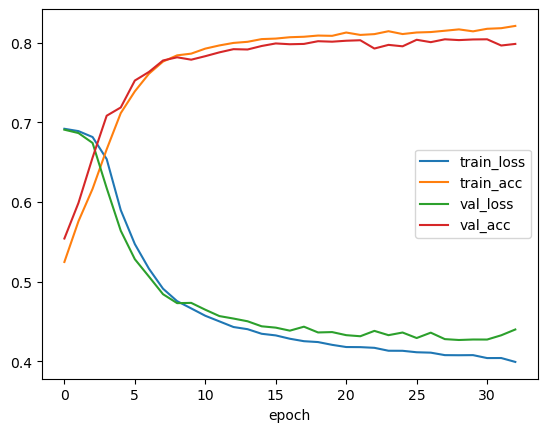

In [17]:
plt.figure()

plt.plot(history.history['loss'], label = 'train_loss')
plt.plot(history.history['accuracy'], label = 'train_acc')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.plot(history.history['val_accuracy'], label = 'val_acc')

plt.legend()
plt.xlabel('epoch')
plt.show()

# 2개의 층을 연결

- 순환층을 연결할 때의 주의점 
    - 순환 층의 은닉 상태는 샘플의 **마지막** **타임스텝에** 대한 은닉 상태만 다음 층으로 전달
        - 순환층을 쌓게 되면 모든 순환층에 순차 데이터가 필요함
        - **앞쪽의** **순환층이** 모든 타임스텝에 대한 은닉 상태를 출력해야함
            - return_sequences 매개변수를 True로 지정 

In [18]:
model3 = keras.Sequential()
model3.add(keras.layers.Embedding(500, 32, input_shape = (100, )))
model3.add(keras.layers.LSTM(8, dropout = 0.3, return_sequences = True))
model3.add(keras.layers.LSTM(8, dropout = 0.3))
model3.add(keras.layers.Dense(1, activation = 'sigmoid'))

In [19]:
model3.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)              │ (None, 100, 32)             │          16,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 100, 8)              │           1,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_4 (LSTM)                        │ (None, 8)                   │             544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │               9 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 17,865 (69.79 KB)

 Trainable params: 17,865 (69.79 KB)

 Non-trainable params: 0 (0.00 B)

- return_sequences = True: 모든 시계열로 값을 내뱉는다 
- (None, 100, 8) : 100개의 타임스텝과 채널 차원이 8개 이다 

- 첫번째 LSTM 
    - 모든 타임스텝(100개) 의 은닉상태를 출력하기 때문에 출력의 크기가 (None, 100, 8)  
- 두번째 LSTM
    - 마지막 타임스텝의 은닉 상태만 출력하기 때문에 출력의 크기가 (None, 8)

In [20]:
(( 32 * 8) + ( 8 * 8) + 8) * 4

1312

In [21]:
((8 * 8) + (8 * 8) + 8) *4

544

In [22]:
rmsprop = keras.optimizers.RMSprop(learning_rate= 1e-4)
model3.compile(optimizer= rmsprop, loss= 'binary_crossentropy', metrics = ['accuracy'])
checkpoint_cb = keras.callbacks.ModelCheckpoint('./model/best-2rnn-model.keras',
                                                save_best_only= True) # 드롭아웃모델 
early_stopping_cb = keras.callbacks.EarlyStopping(patience = 4, restore_best_weights= True)

In [23]:
history= model3.fit(train_seq, y_train, epochs= 100, batch_size = 64,
                   validation_data= (val_seq, y_val),
                   callbacks= [checkpoint_cb, early_stopping_cb])

Epoch 1/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 15s 39ms/step - accuracy: 0.5117 - loss: 0.6928 - val_accuracy: 0.5682 - val_loss: 0.6914
Epoch 2/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 12s 38ms/step - accuracy: 0.5763 - loss: 0.6900 - val_accuracy: 0.6374 - val_loss: 0.6835
Epoch 3/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 12s 38ms/step - accuracy: 0.6095 - loss: 0.6783 - val_accuracy: 0.6884 - val_loss: 0.6394
Epoch 4/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 12s 38ms/step - accuracy: 0.6832 - loss: 0.6301 - val_accuracy: 0.7246 - val_loss: 0.5884
Epoch 5/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 11s 37ms/step - accuracy: 0.7239 - loss: 0.5842 - val_accuracy: 0.7330 - val_loss: 0.5633
Epoch 6/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 11s 35ms/step - accuracy: 0.7416 - loss: 0.5576 - val_accuracy: 0.7520 - val_loss: 0.5369
Epoch 7/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 11s 35ms/step - accuracy: 0.7552 - loss: 0.5357 - val_accuracy: 0.7566 - val_loss: 0.5260
Epoch 8/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 12s 37ms/step - accuracy: 0.7647 - loss: 0

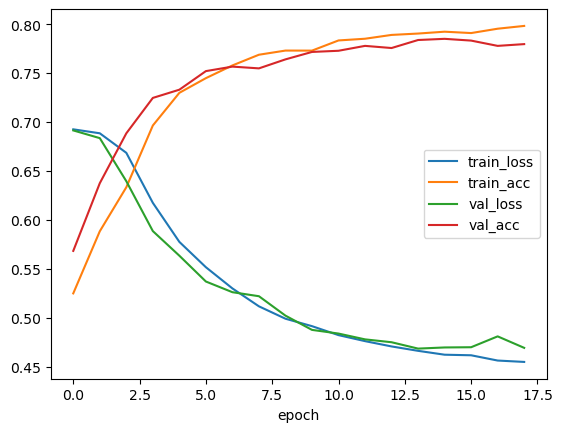

In [24]:
plt.figure()

plt.plot(history.history['loss'], label = 'train_loss')
plt.plot(history.history['accuracy'], label = 'train_acc')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.plot(history.history['val_accuracy'], label = 'val_acc')

plt.legend()
plt.xlabel('epoch')
plt.show()

# GRU(Grated Recurrent Unit) 구조 

<img src = './image/rnn_lstm_gru.png'>

- LSTM을 간소화한 버전
- LSTM처럼 셀 상태를 계산하지 않고 은닉 상태 하나만 포함
- LSTM보다 가중치가 적기 때문에 계산량이 적지만 성능은 LSTM과 유사함 
    - 데이터 양이 적을 때는 GRU의 성능이 더 좋고 데이터 양이 많을 때는 LSTM의 성능이 더 좋아지는 경향이 있음
    - GRU와 LSTM 중 어떤 것이 더 낫다 라고 말할 수는 없음 

<img src = './image/gru.png'>

- 빨간색이 시그모이드 함수
- 파랑색이 탄젠트 함수

- GRU 셀에는 은닉 상태와 입력에 가중치를 곱하고 절편을 더하는 작은 셀 3개가 들어 있음
    - 2개는 시그모이드 활성화 함수를 사용하고 tanh 활성화 함수를 사용 
    
    
- reset_gate
    - 셀의 출력이 은닉 상태에 바로 곱해져서 삭제 게이트 역할을 수행 
    
    
- update_gate
    - 어떤 정보를 얼마만큼 유지하고 어떤 정보를 추가할지 결정하는 역할 

In [45]:
# GRU 모델 생성
model4 = keras.Sequential()
model4.add(keras.layers.Embedding(500, 32, input_shape = (100, ))) # 100 개의 단어를 쓸것임
model4.add(keras.layers.GRU(8)) # 유닛 8 개를 쓺 
model4.add(keras.layers.Dense(1, activation = 'sigmoid'))

In [46]:
model4.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_5 (Embedding)              │ (None, 100, 32)             │          16,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru (GRU)                            │ (None, 8)                   │           1,008 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │               9 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 17,017 (66.47 KB)

 Trainable params: 17,017 (66.47 KB)

 Non-trainable params: 0 (0.00 B)

In [51]:
((32 * 8) + (8 * 8) + 8 + 8) * 3

1008

In [52]:
rmsprop = keras.optimizers.RMSprop(learning_rate= 1e-4)
model4.compile(optimizer= rmsprop, loss= 'binary_crossentropy', metrics = ['accuracy'])
checkpoint_cb = keras.callbacks.ModelCheckpoint('./model/best-gru-model.keras',
                                                save_best_only= True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience = 4, restore_best_weights= True)

In [53]:
history= model4.fit(train_seq, y_train, epochs= 100, batch_size = 64,
                   validation_data= (val_seq, y_val),
                   callbacks= [checkpoint_cb, early_stopping_cb])

Epoch 1/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - accuracy: 0.5294 - loss: 0.6920 - val_accuracy: 0.5534 - val_loss: 0.6908
Epoch 2/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - accuracy: 0.5593 - loss: 0.6898 - val_accuracy: 0.5714 - val_loss: 0.6881
Epoch 3/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - accuracy: 0.5794 - loss: 0.6862 - val_accuracy: 0.5928 - val_loss: 0.6842
Epoch 4/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step - accuracy: 0.5946 - loss: 0.6815 - val_accuracy: 0.6004 - val_loss: 0.6787
Epoch 5/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - accuracy: 0.6080 - loss: 0.6743 - val_accuracy: 0.6046 - val_loss: 0.6713
Epoch 6/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - accuracy: 0.6129 - loss: 0.6666 - val_accuracy: 0.6212 - val_loss: 0.6610
Epoch 7/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - accuracy: 0.6264 - loss: 0.6551 - val_accuracy: 0.6388 - val_loss: 0.6466
Epoch 8/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - accuracy: 0.6487 - loss: 0.6381 -

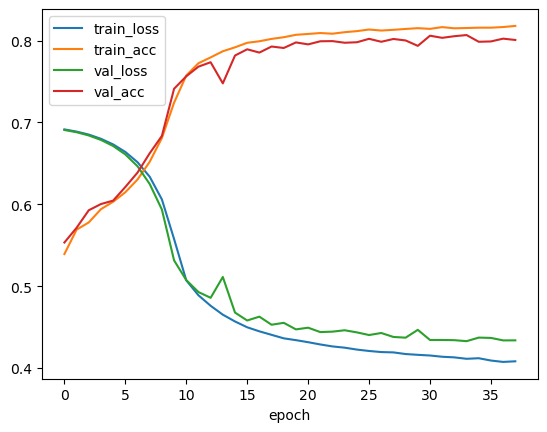

In [54]:
plt.figure()

plt.plot(history.history['loss'], label = 'train_loss')
plt.plot(history.history['accuracy'], label = 'train_acc')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.plot(history.history['val_accuracy'], label = 'val_acc')

plt.legend()
plt.xlabel('epoch')
plt.show()

- 보통은 GRU가 LSTM 보다 성능이 잘 나옴

# best model 검증

In [55]:
test_seq = pad_sequences(x_test, maxlen=100)
rnn_model = keras.models.load_model('./model/best-dropout-model.keras')
rnn_model.evaluate(test_seq, y_test)

782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.8067 - loss: 0.4226


[0.4245913624763489, 0.8044000267982483]